In [33]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# 1. Lecture du fichier
df = pd.read_csv("data\Kangaroo.csv")

### Drop columns

In [34]:

# 2. Liste des colonnes à supprimer 
cols_to_drop = [
    "Unnamed: 0", "id", "url", "roomCount", "monthlyCost",
    "hasAttic", "hasBasement", "hasDressingRoom", "diningRoomSurface", "hasDiningRoom",
    "streetFacadeWidth", "hasLift", "hasHeatPump",
    "hasPhotovoltaicPanels", "hasThermicPanels", "kitchenSurface",
    "hasLivingRoom", "livingRoomSurface", "hasBalcony",
    "gardenOrientation", "parkingCountIndoor", "parkingCountOutdoor",
    "hasAirConditioning", "hasArmoredDoor", "hasVisiophone", "hasOffice",
    "terraceSurface", "terraceOrientation", "accessibleDisabledPeople"
]

# 3. Suppression
df.drop(cols_to_drop, axis=1, inplace=True)

### Grouping subtypes

In [35]:
# Subtype_grouped
subtype_mapping = {
    'EXCEPTIONAL_PROPERTY': 'LUXURY_PROPERTY',
    'VILLA': 'LUXURY_PROPERTY',
    'MANSION': 'LUXURY_PROPERTY',
    'CASTLE': 'LUXURY_PROPERTY',
    'MANOR_HOUSE': 'LUXURY_PROPERTY',
    'HOUSE': 'STANDARD_HOUSE',
    'TOWN_HOUSE': 'STANDARD_HOUSE',
    'BUNGALOW': 'STANDARD_HOUSE',
    'PAVILION': 'STANDARD_HOUSE',
    'COUNTRY_COTTAGE': 'RURAL_HOUSE',
    'FARMHOUSE': 'RURAL_HOUSE',
    'CHALET': 'RURAL_HOUSE',
    'APARTMENT': 'STANDARD_APARTMENT',
    'GROUND_FLOOR': 'STANDARD_APARTMENT',
    'FLAT_STUDIO': 'STANDARD_APARTMENT',
    'SERVICE_FLAT': 'STANDARD_APARTMENT',
    'KOT': 'STANDARD_APARTMENT',
    'PENTHOUSE': 'SPECIAL_APARTMENT',
    'DUPLEX': 'SPECIAL_APARTMENT',
    'TRIPLEX': 'SPECIAL_APARTMENT',
    'LOFT': 'SPECIAL_APARTMENT',
    'MIXED_USE_BUILDING': 'MIXED_USE',
    'OTHER_PROPERTY': 'OTHER'
}
# Appliquer le mapping
df['subtype_grouped'] = df['subtype'].map(subtype_mapping)
# Drop column: 'subtype'
df = df.drop(columns=['subtype'])

### Check and drop Outliers

Data visualization for outliers

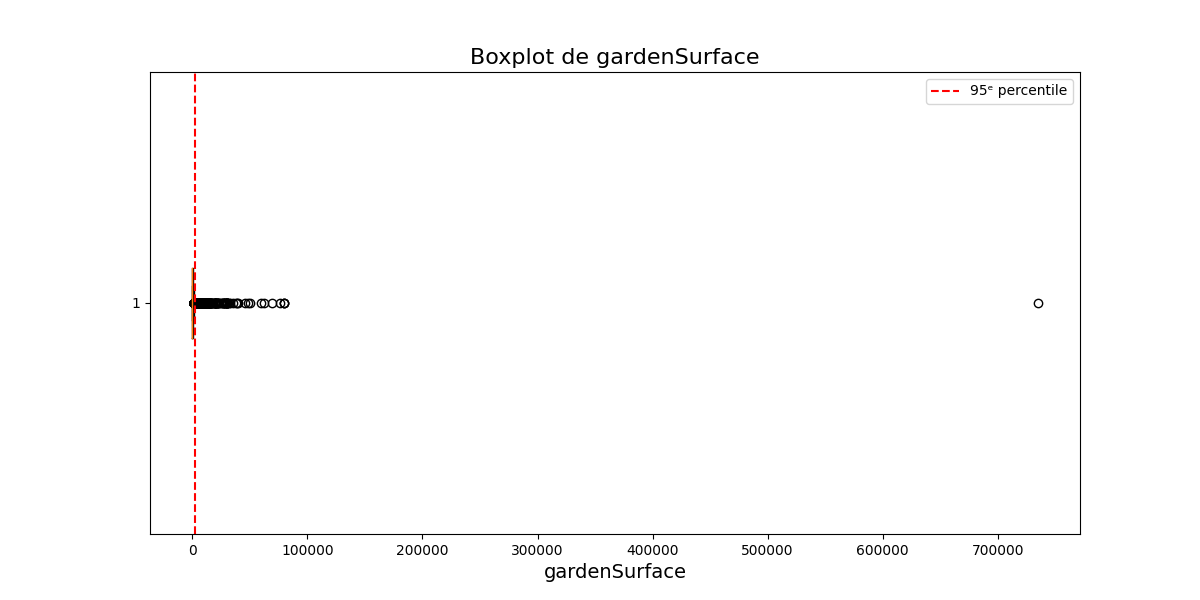

10ᵉ percentile : 10
90ᵉ percentile : 1250
95ᵉ percentile : 2241
Biens > p90 : 1589 soit 1.98%
Biens > p95 : 798 soit 0.99%
Biens < p10 : 1563 soit 1.94%
Mode de gardenSurface : 1.0


In [36]:
#Datavisualization for outliers

# Sans NaN
data = df["gardenSurface"].dropna()


p10, p90, p95 = data.quantile([0.10, 0.90, 0.95]).values

# 3) Boxplot horizontal avec ligne pour le 95ᵉ percentile
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(data, vert=False, showfliers=True)
ax.axvline(p95, color="red", linestyle="--", label="95ᵉ percentile")
ax.set_title("Boxplot de gardenSurface", fontsize=16)
ax.set_xlabel("gardenSurface", fontsize=14)
ax.legend()
plt.show()


# 4) Affichage des percentiles et des effectifs
print(f"10ᵉ percentile : {p10:.0f}")
print(f"90ᵉ percentile : {p90:.0f}")
print(f"95ᵉ percentile : {p95:.0f}")

total = len(df)
n_above_p90 = (df['gardenSurface'] > p90).sum()
n_above_p95 = (df['gardenSurface'] > p95).sum()
n_below_p10 = (df['gardenSurface'] < p10).sum()

print(f"Biens > p90 : {n_above_p90} soit {n_above_p90/total:.2%}")
print(f"Biens > p95 : {n_above_p95} soit {n_above_p95/total:.2%}")
print(f"Biens < p10 : {n_below_p10} soit {n_below_p10/total:.2%}")

# 5) Calcul et affichage du mode (première valeur si plusieurs)
mode_floor = df['gardenSurface'].mode().iloc[0]
print(f"Mode de gardenSurface : {mode_floor}")


In [37]:
# Fermer graph pour libérer la mémoire
plt.close("all")

Keep bedrooms <= 7

In [38]:
df = df[
    (df["bedroomCount"] <= 7) | df["bedroomCount"].isna()
]


Keep houses contructed between 1850 and 2025

In [39]:
df = df[
    (df["buildingConstructionYear"].between(1850, 2025)) | df["buildingConstructionYear"].isna()
]

Bathrooms count <= 3

In [40]:
df = df[
    (df["bathroomCount"] <= 3) | df["bathroomCount"].isna()
]

Habitable surface

In [41]:
# Fourchettte entre 5 et 500 m² pour rester dans un marché immo le plus représentatif
df_domain = df[(df["habitableSurface"] >= 5) & (df["habitableSurface"] <= 500)]

Facede count
Max. 4

In [42]:
df = df[
    (df["facedeCount"] <= 4) | df["facedeCount"].isna()
]

FloorCount

 Séparation du champ unique `floorCount` en deux colonnes distinctes :
  - `building_floors`  : nombre total d'étages du bâtiment (valide pour les maisons)
  - `apartment_floor`  : étage où se situe l’appartement (valide pour les appartements)
  
 Méthode :
 1) On teste, ligne par ligne, si `propertyType` vaut "house" ou "apartment".
 2) Si c'est une maison, on recopie `floorCount` dans `building_floors` et on met NaN dans `apartment_floor`.
 3) Si c'est un appartement, on recopie `floorCount` dans `apartment_floor` et on met NaN dans `building_floors`.
 4) Enfin, on supprime l’ancienne colonne `floorCount` car elle n’est plus nécessaire.


In [43]:

df['building_floors'] = np.where(
    df['type'] == 'HOUSE',
    df['floorCount'],
    np.nan
)

df['apartment_floor'] = np.where(
    df['type'] == 'APARTMENT',
    df['floorCount'],
    np.nan
)

df = df.drop(columns=['floorCount'])


landSurface

<= 2000 m²

In [44]:
df = df[
    (df["landSurface"] <= 2000) | df["landSurface"].isna()
]

Garden surface :
- Drop outliers > 2000 m²
- If NaN, it's because there is not garden because the col hasGarden have the same values missings count
- Convert hasGarden in bool
- If hasGarden = False --> gardenSurface = 0

In [ ]:
# Drop outliers
df = df[
    (df["gardenSurface"] <= 2000) | df["gardenSurface"].isna()
]

# Convert hasGaren in bool
df['hasGarden'] = df['hasGarden'].fillna(False).astype(bool)
print(df['hasGarden'].dtype)

# False --> 0
df.loc[df['hasGarden'] == False, 'gardenSurface'] = 0

# print(df[['hasGarden','gardenSurface']].head(10))


bool
   hasGarden  gardenSurface
0      False            0.0
1       True          100.0
2      False            0.0
3      False            0.0
4      False            0.0
5      False            0.0
6      False            0.0
7      False            0.0
8      False            0.0
9      False            0.0
